In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean

In [3]:
df = pd.read_csv('./data/final_annotations_duplicatesTagged_modTBDs - final_annotations_duplicatesTagged.csv')

In [4]:
df.drop(['sentence', 'sentiments','impacts', 'film_title', 'batch', 'impact'], axis = 1, inplace = True) ## drop columns that are not needed
df = df[df['duplicated'] != True] # remove duplicates from the dataset
df.drop(['duplicated'], axis = 1, inplace = True) ## drop columns that are not needed

In [5]:
df.head()

,sentiment,sentences_nopunc
0,Negative,a few spots were boring
1,Negative,we landed probes on mars and orbited celestial...
2,Negative,very dry and unimaginative
3,Negative,it seemed a bit repetitive
4,Negative,i didnt watch it past 4 minutes


In [6]:
df.value_counts('sentiment')

sentiment
Positive    603
Negative    370
Neutral     217
dtype: int64

In [7]:
X = df['sentences_nopunc']
y = df['sentiment']

y = y.map({'Positive': 0, 'Negative': 1, 'Neutral': 2})

# sentiment analysis while using SMOTE for oversampling the minority class and weight balancing both for training and testing data

In [8]:
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

vectorizer = CountVectorizer(stop_words = stop_words, tokenizer = lemmatize_text)
X = vectorizer.fit_transform(df["sentences_nopunc"])

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y                                                    
                                    )

class_weights = dict(zip(np.unique(y), class_weights))

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

## split the data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training XGBoost classifier model

In [9]:
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_test = xgbModel.predict(X_test)
y_pred_train = xgbModel.predict(X_train)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.8742225293711127
Accuracy on testing data:  0.7182320441988951
              precision    recall  f1-score   support

           0       0.83      0.51      0.64       136
           1       0.83      0.77      0.80       118
           2       0.59      0.92      0.72       108

    accuracy                           0.72       362
   macro avg       0.75      0.73      0.72       362
weighted avg       0.76      0.72      0.71       362



## Confusion Matrix for Train and Test datasets

<AxesSubplot: >

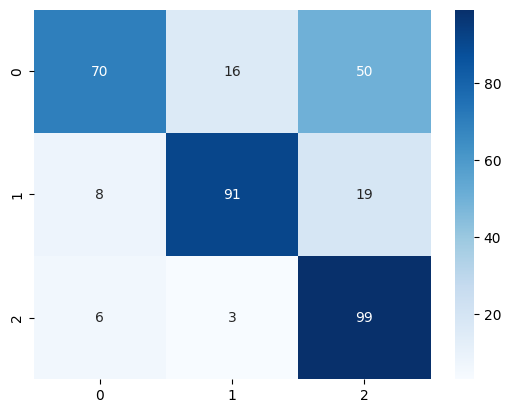

In [10]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

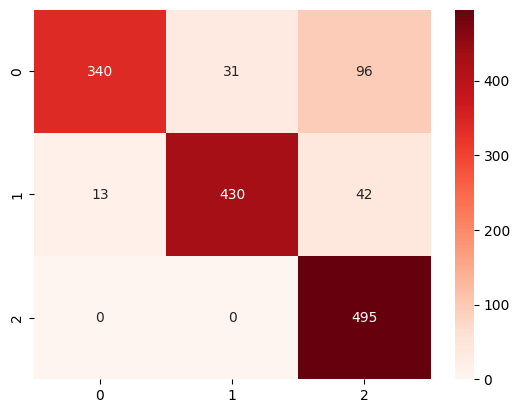

In [11]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

## Training Random Forest Classifier Model

In [12]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = rfModel.predict(X_train)
y_pred_test = rfModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.9143054595715273
Accuracy on testing data:  0.5994475138121547
              precision    recall  f1-score   support

           0       0.74      0.51      0.61       136
           1       0.57      0.46      0.51       118
           2       0.53      0.86      0.66       108

    accuracy                           0.60       362
   macro avg       0.62      0.61      0.59       362
weighted avg       0.63      0.60      0.59       362



## confusion matrix for train and test data

<AxesSubplot: >

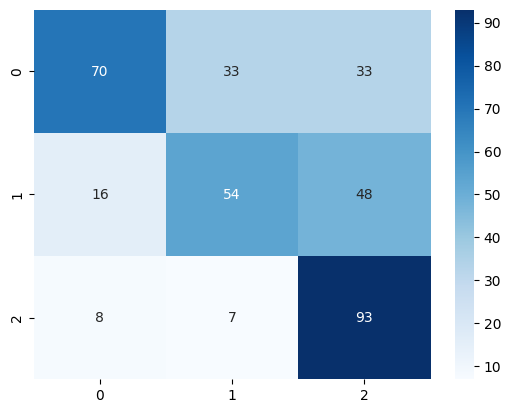

In [13]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

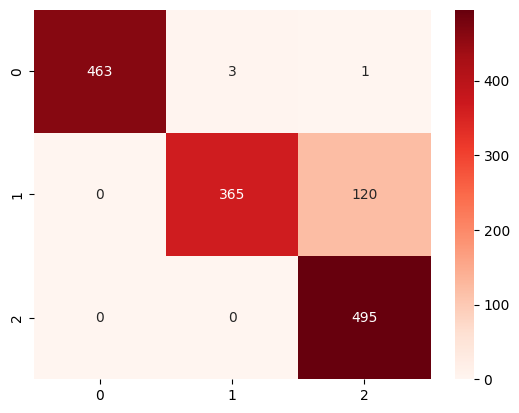

In [14]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

## training ADABoost classifier

In [15]:
adaModel = AdaBoostClassifier()
adaModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = adaModel.predict(X_train)
y_pred_test = adaModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.6012439530062198
Accuracy on testing data:  0.5138121546961326
              precision    recall  f1-score   support

           0       0.78      0.43      0.56       136
           1       0.58      0.25      0.35       118
           2       0.42      0.91      0.57       108

    accuracy                           0.51       362
   macro avg       0.59      0.53      0.49       362
weighted avg       0.60      0.51      0.49       362



## Confusion Matrix for training and testing data

<AxesSubplot: >

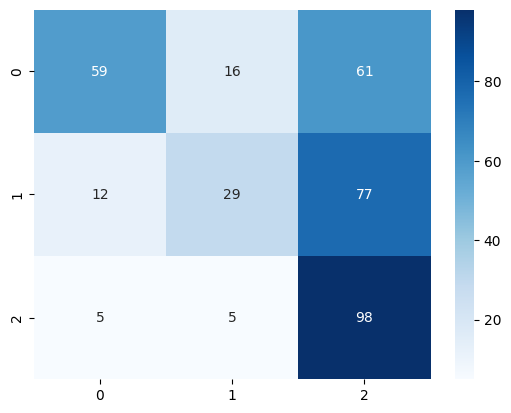

In [16]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

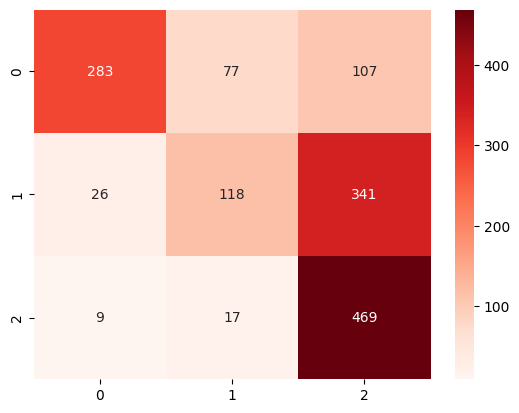

In [17]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

# sentiment analysis while using class weights and SMOTE only for the testing data

In [18]:
X = df['sentences_nopunc']
y = df['sentiment']

y = y.map({'Positive': 0, 'Negative': 1, 'Neutral': 2})

In [19]:
X = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = sm.fit_resample(X_test, y_test) 

## Training XGBoost Classifier model

In [20]:
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_test = xgbModel.predict(X_test)
y_pred_train = xgbModel.predict(X_train)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.8634453781512605
Accuracy on testing data:  0.4562841530054645
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       122
           1       0.52      0.43      0.47       122
           2       0.40      0.39      0.40       122

    accuracy                           0.46       366
   macro avg       0.46      0.46      0.45       366
weighted avg       0.46      0.46      0.45       366



## Confusion matrix for training and testing data

<AxesSubplot: >

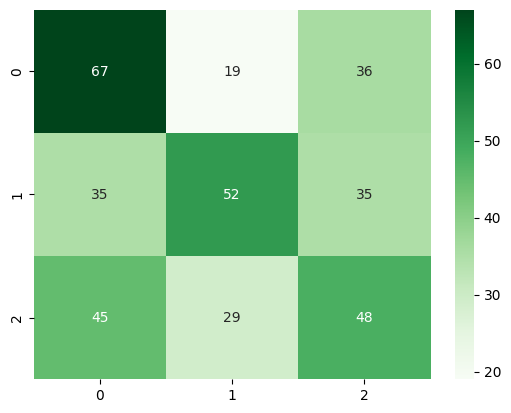

In [21]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

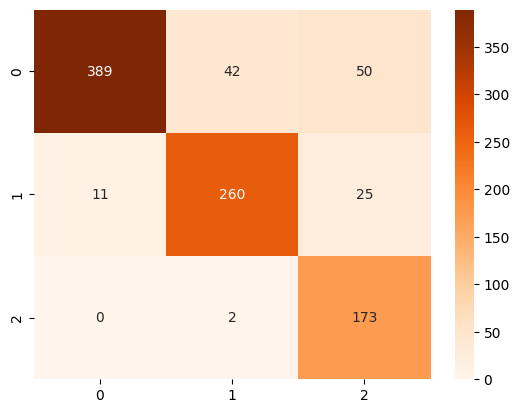

In [22]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')

## Training Random Forest Classifier Model

In [23]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = rfModel.predict(X_train)
y_pred_test = rfModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.9989495798319328
Accuracy on testing data:  0.5546448087431693
              precision    recall  f1-score   support

           0       0.62      0.66      0.63       122
           1       0.55      0.22      0.32       122
           2       0.51      0.79      0.62       122

    accuracy                           0.55       366
   macro avg       0.56      0.55      0.52       366
weighted avg       0.56      0.55      0.52       366



<AxesSubplot: >

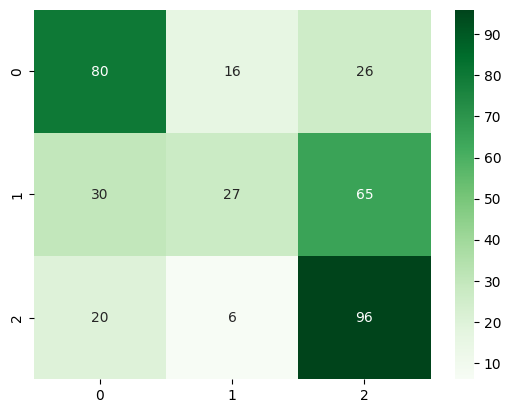

In [24]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

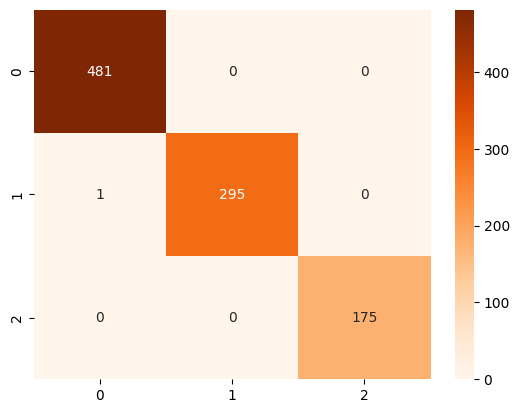

In [25]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')

## Training ADaBoost Classifier

In [26]:
adaModel = AdaBoostClassifier()
adaModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = adaModel.predict(X_train)
y_pred_test = adaModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.5619747899159664
Accuracy on testing data:  0.4890710382513661
              precision    recall  f1-score   support

           0       0.76      0.36      0.49       122
           1       0.48      0.18      0.26       122
           2       0.43      0.93      0.59       122

    accuracy                           0.49       366
   macro avg       0.56      0.49      0.45       366
weighted avg       0.56      0.49      0.45       366



<AxesSubplot: >

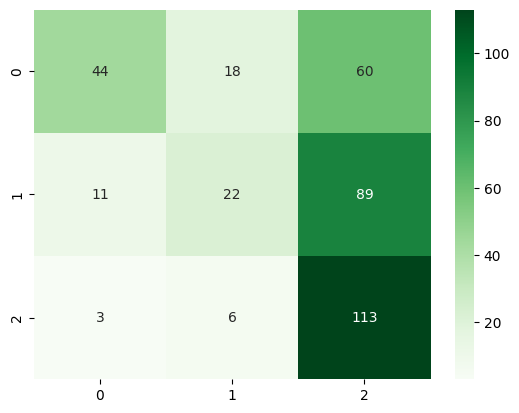

In [27]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

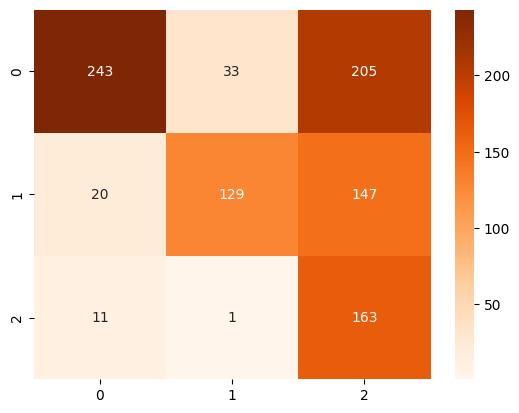

In [28]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')

## Using Stratified Cross Validation for XGBoost

In [29]:
X = df['sentences_nopunc']
y = df['sentiment']

y = y.map({'Positive': 0, 'Negative': 1, 'Neutral': 2})

X = vectorizer.fit_transform(X)

X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## using stratified k fold cross validation

In [30]:
xgbModel = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
accuracy_list_train = []
accuracy_list_test = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))
    y_pred_train = xgbModel.predict(X_train)
    y_pred_test = xgbModel.predict(X_test)
    accuracy_list_test.append(accuracy_score(y_test, y_pred_test))
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))

print("max Accuracy on testing data: ", max(accuracy_list_test))
print("mean Accuracy on testing data: ", mean(accuracy_list_test))
print("max Accuracy on training data: ", max(accuracy_list_train))
print("mean Accuracy on training data: ", mean(accuracy_list_train))

max Accuracy on testing data:  0.7955801104972375
mean Accuracy on testing data:  0.7191559238796807
max Accuracy on training data:  0.8765356265356266
mean Accuracy on training data:  0.8730422788433838
